# 🚗 Predict Vehicle Prices — End-to-End ML Notebook

**Goal:** Build a model to predict vehicle **price** using specs like make/model, year, mileage, body, engine, transmission, colors, etc.  
We’ll cover EDA, preprocessing, modeling (Linear/Ridge, RandomForest, XGBoost/LightGBM optional), evaluation (MAE/RMSE/R²), and model export.

*Columns per objective:* `name, description, make, model, year, price, engine, cylinders, fuel, mileage, transmission, trim, body, doors, exterior_color, interior_color, drivetrain` (see project brief).  


In [12]:
# Section 1 — Imports & Config
import warnings, os, re, math, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries ready")

✅ Libraries ready


In [13]:
# Section 2 — Load data
DATA_PATH = "dataset.csv"  
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (1002, 17)


,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

None


Missing values per column:
 name                0
description        56
make                0
model               0
year                0
price              23
engine              2
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64

Basic stats:



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,1002,358,2023 Dodge Durango Pursuit,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,946,761,\n \n .\n \n,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
make,1002,28,Jeep,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,1002,153,Hornet,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,1002.0,NaN,NaN,NaN,2023.916168,0.298109,2023.0,2024.0,2024.0,2024.0,2025.0
price,979.0,NaN,NaN,NaN,50202.9857,18700.392062,0.0,36600.0,47165.0,58919.5,195895.0
engine,1000,100,16V GDI DOHC Turbo,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,897.0,NaN,NaN,NaN,4.975474,1.392526,0.0,4.0,4.0,6.0,8.0
fuel,995,7,Gasoline,664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,968.0,NaN,NaN,NaN,69.033058,507.435745,0.0,4.0,8.0,13.0,9711.0


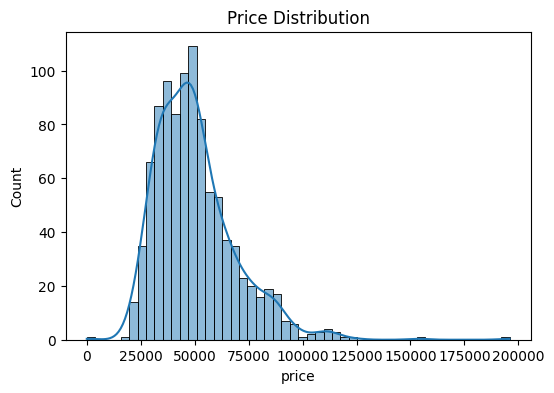

In [14]:
# Section 3 — Overview & sanity checks
display(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nBasic stats:\n"); display(df.describe(include='all').transpose())

# Target distribution (price)
plt.figure(figsize=(6,4))
sns.histplot(df['price'].dropna(), bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

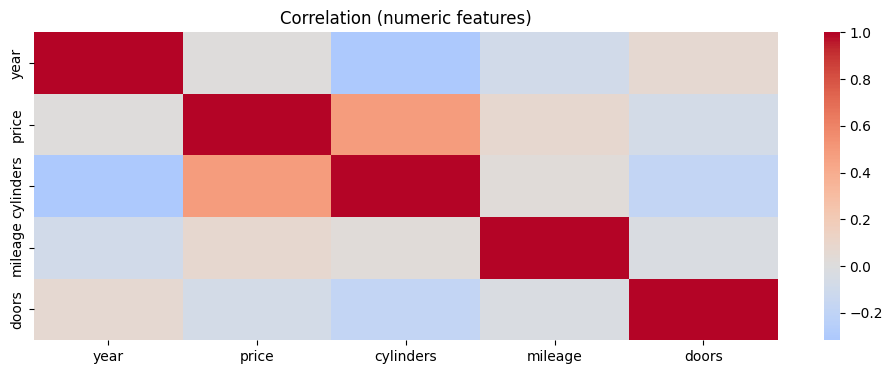

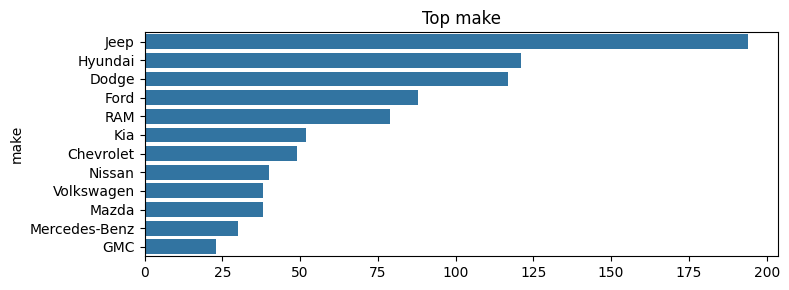

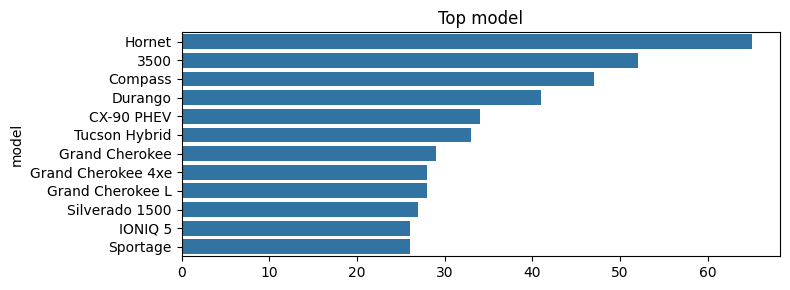

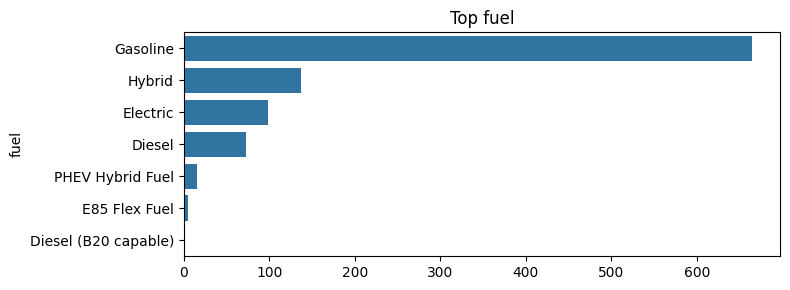

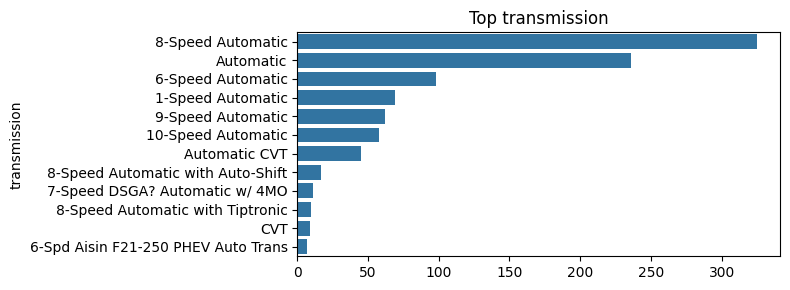

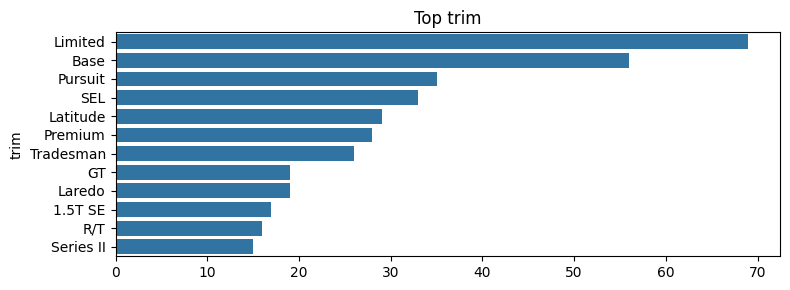

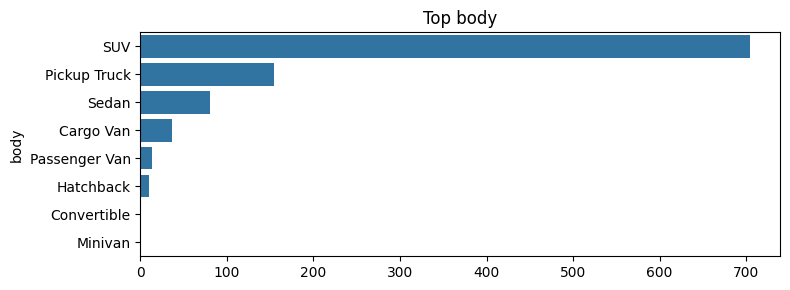

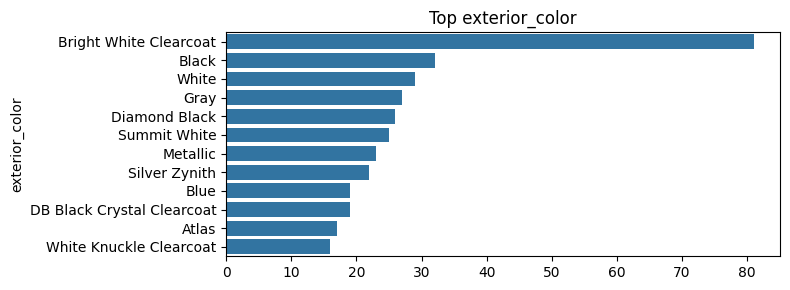

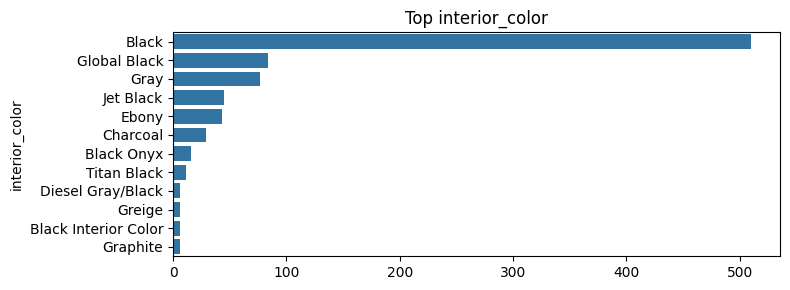

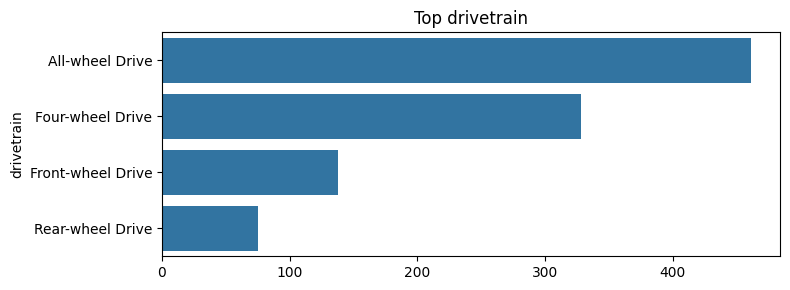

In [15]:
# Section 4 — EDA
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,4))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation (numeric features)")
plt.show()

# top categorical counts
cat_cols = [
    'make','model','fuel','transmission','trim','body',
    'exterior_color','interior_color','drivetrain'
]
for c in cat_cols:
    if c in df.columns:
        vc = df[c].value_counts().head(12)
        plt.figure(figsize=(8,3)); sns.barplot(x=vc.values, y=vc.index)
        plt.title(f"Top {c}"); plt.tight_layout(); plt.show()

In [16]:
# Section 5 — Feature engineering helpers

def extract_engine_features(s):
    if not isinstance(s, str) or not s.strip():
        return {"displacement_l": np.nan, "horsepower": np.nan}
    text = s.lower()
    # displacement like 2.0l, 3.5 l
    disp_match = re.search(r'(\d+(\.\d+)?)\s*l', text)
    displacement = float(disp_match.group(1)) if disp_match else np.nan
    # horsepower like 240hp, 300 hp
    hp_match = re.search(r'(\d{2,4})\s*hp', text)
    horsepower = float(hp_match.group(1)) if hp_match else np.nan
    return {"displacement_l": displacement, "horsepower": horsepower}

def add_simple_text_features(df_in):
    df_out = df_in.copy()
    for col in ['name','description']:
        if col in df_out.columns:
            s = df_out[col].fillna("")
            df_out[f"{col}_len"]  = s.str.len()
            df_out[f"{col}_words"] = s.apply(lambda x: len(x.split()))
    return df_out

# Apply simple text len/wordcount features
df = add_simple_text_features(df)

# Expand engine features into numeric columns
if 'engine' in df.columns:
    eng_df = df['engine'].apply(extract_engine_features).apply(pd.Series)
    df = pd.concat([df, eng_df], axis=1)

print("Added engineered features:")
cols_added = [c for c in ['name_len','name_words','description_len','description_words','displacement_l','horsepower'] if c in df.columns]
print(cols_added)


Added engineered features:
['name_len', 'name_words', 'description_len', 'description_words', 'displacement_l', 'horsepower']


In [17]:
# Section 6 — Train/Test Split
TARGET = 'price'
assert TARGET in df.columns, "The dataset must contain a 'price' column."

# Drop rows with missing target
df = df[~df[TARGET].isna()].reset_index(drop=True)

# Define feature columns
potential_numeric = ['year','mileage','cylinders','doors','name_len','name_words','description_len','description_words','displacement_l','horsepower']
numeric_features = [c for c in potential_numeric if c in df.columns]

categorical_features = [c for c in [
    'make','model','fuel','transmission','trim','body',
    'exterior_color','interior_color','drivetrain'
] if c in df.columns]

text_features = [c for c in ['name','description'] if c in df.columns]

X = df[[c for c in (numeric_features + categorical_features + text_features) if c in df.columns]].copy()
y = df[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)
print("Text:", text_features)

Train: (783, 21) Test: (196, 21)
Numeric: ['year', 'mileage', 'cylinders', 'doors', 'name_len', 'name_words', 'description_len', 'description_words', 'displacement_l', 'horsepower']
Categorical: ['make', 'model', 'fuel', 'transmission', 'trim', 'body', 'exterior_color', 'interior_color', 'drivetrain']
Text: ['name', 'description']


In [18]:
# Section 7 — Preprocessor (fixed for missing text)

# numeric: impute median + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# categorical: impute 'Unknown' + OneHot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01))
])

# text preprocessing — fill NaN before TF-IDF
def fill_missing_text(df):
    """Replace NaN text with empty string for TF-IDF safety"""
    return df.fillna("")

text_transformers = []
if 'name' in text_features:
    text_transformers.append((
        "name_tfidf",
        Pipeline([
            ("fillna", FunctionTransformer(fill_missing_text)),
            ("tfidf", TfidfVectorizer(max_features=800, ngram_range=(1,2)))
        ]),
        "name"
    ))
if 'description' in text_features:
    text_transformers.append((
        "desc_tfidf",
        Pipeline([
            ("fillna", FunctionTransformer(fill_missing_text)),
            ("tfidf", TfidfVectorizer(max_features=1500, ngram_range=(1,2), min_df=3))
        ]),
        "description"
    ))

# Combine all preprocessors
transformers = []
if numeric_features:
    transformers.append(("num", numeric_transformer, numeric_features))
if categorical_features:
    transformers.append(("cat", categorical_transformer, categorical_features))
transformers.extend(text_transformers)

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

print("✅ Preprocessor ready (with text NaN handling)")


✅ Preprocessor ready (with text NaN handling)


In [22]:
# Section 8 — Fixed Metrics Helper (works on all sklearn versions)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def regression_report(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle old sklearn versions without 'squared' param
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r2 = r2_score(y_true, y_pred)
    print(f"{label} — MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    return {"mae": mae, "rmse": rmse, "r2": r2}


In [23]:
# Section 9 — Baselines: Linear & Ridge

models = {}

# Linear Regression
linreg = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", LinearRegression())
])
linreg.fit(X_train, y_train)
pred_lr = linreg.predict(X_test)
metrics_lr = regression_report(y_test, pred_lr, "LinearRegression")
models["LinearRegression"] = (linreg, metrics_lr)

# Ridge (light tuning)
ridge = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE))
])
param_grid_ridge = {"model__alpha": [0.1, 1.0, 5.0, 10.0]}
g_ridge = GridSearchCV(ridge, param_grid_ridge, scoring="neg_root_mean_squared_error", cv=3, n_jobs=-1)
g_ridge.fit(X_train, y_train)
pred_ridge = g_ridge.predict(X_test)
metrics_ridge = regression_report(y_test, pred_ridge, f"Ridge (best α={g_ridge.best_params_['model__alpha']})")
models["Ridge"] = (g_ridge.best_estimator_, metrics_ridge)

print("✅ Baselines trained")

LinearRegression — MAE: 23,399.48 | RMSE: 47,202.34 | R²: -6.2958
Ridge (best α=0.1) — MAE: 3,983.57 | RMSE: 6,831.94 | R²: 0.8472
✅ Baselines trained


In [24]:
# Section 10 — RandomForestRegressor

rf = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
metrics_rf = regression_report(y_test, pred_rf, "RandomForest")
models["RandomForest"] = (rf, metrics_rf)

RandomForest — MAE: 5,125.24 | RMSE: 8,076.88 | R²: 0.7864


In [25]:
# Section 11 — Optional: XGBoost & LightGBM

try:
    from xgboost import XGBRegressor
    xgb = Pipeline(steps=[
        ("pre", preprocessor),
        ("model", XGBRegressor(
            n_estimators=600, learning_rate=0.05, max_depth=8,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
            tree_method="hist", reg_lambda=1.0
        ))
    ])
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)
    metrics_xgb = regression_report(y_test, pred_xgb, "XGBoost")
    models["XGBoost"] = (xgb, metrics_xgb)
except Exception as e:
    print("XGBoost skipped:", e)

try:
    from lightgbm import LGBMRegressor
    lgbm = Pipeline(steps=[
        ("pre", preprocessor),
        ("model", LGBMRegressor(
            n_estimators=600, learning_rate=0.05, num_leaves=63,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
        ))
    ])
    lgbm.fit(X_train, y_train)
    pred_lgbm = lgbm.predict(X_test)
    metrics_lgbm = regression_report(y_test, pred_lgbm, "LightGBM")
    models["LightGBM"] = (lgbm, metrics_lgbm)
except Exception as e:
    print("LightGBM skipped:", e)

print("✅ Gradient boosting (optional) done")

XGBoost — MAE: 4,360.32 | RMSE: 7,348.60 | R²: 0.8232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28026
[LightGBM] [Info] Number of data points in the train set: 783, number of used features: 1534
[LightGBM] [Info] Start training from score 50193.708812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Model,MAE,RMSE,R2
1,Ridge,3983.572873,6831.937026,0.847162
3,XGBoost,4360.322824,7348.597324,0.823171
2,RandomForest,5125.236284,8076.879605,0.786385
4,LightGBM,5092.100475,8758.398244,0.748815
0,LinearRegression,23399.476581,47202.335731,-6.295778


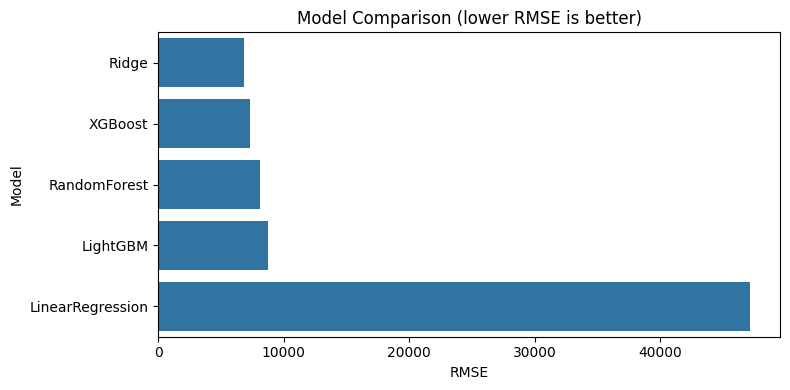

🏆 Best model: Ridge | RMSE=6831.94, MAE=3983.57, R²=0.8472


In [26]:
# Section 12 — Model comparison table & bar chart
rows = []
for name, (_, m) in models.items():
    rows.append({"Model": name, "MAE": m["mae"], "RMSE": m["rmse"], "R2": m["r2"]})
results_df = pd.DataFrame(rows).sort_values("RMSE")
display(results_df)

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="RMSE", y="Model")
plt.title("Model Comparison (lower RMSE is better)")
plt.tight_layout(); plt.show()

best_row = results_df.iloc[0]
best_name = best_row["Model"]
print(f"🏆 Best model: {best_name} | RMSE={best_row['RMSE']:.2f}, MAE={best_row['MAE']:.2f}, R²={best_row['R2']:.4f}")

In [27]:
# Section 13 — Save best model & separate preprocessor 
best_model = models[best_name][0]
joblib.dump(best_model, "best_vehicle_price_model.joblib")
print("Saved:", os.path.abspath("best_vehicle_price_model.joblib"))

# Extract from pipeline safely (works for pipelines defined above)
if isinstance(best_model, Pipeline) and "pre" in dict(best_model.named_steps):
    preproc_only = best_model.named_steps["pre"]
    joblib.dump(preproc_only, "preprocessor.joblib")
    print("Saved:", os.path.abspath("preprocessor.joblib"))


Saved: c:\Users\sharm\Desktop\Vehicle Price Prediction\best_vehicle_price_model.joblib
Saved: c:\Users\sharm\Desktop\Vehicle Price Prediction\preprocessor.joblib


In [28]:
# Section 14 — Predict on new data helper

def predict_prices(df_new, model_path="best_vehicle_price_model.joblib"):
    model_loaded = joblib.load(model_path)
    preds = model_loaded.predict(df_new)
    return preds

# Example with one row from test set (drop price if present)
example = X_test.iloc[:1].copy()
print("Example features:\n", example)
print("Predicted price:", predict_prices(example)[0])


Example features:
      year  mileage  cylinders  doors  name_len  name_words  description_len  \
199  2024     13.0        4.0    4.0        29           5              693   

     description_words  displacement_l  horsepower  ...        model    fuel  \
199                108             6.0         NaN  ...  Elantra HEV  Hybrid   

    transmission  trim   body  exterior_color interior_color  \
199    Automatic  Blue  Sedan  Serenity White    Medium Gray   

            drivetrain                           name  \
199  Front-wheel Drive  2024 Hyundai Elantra HEV Blue   

                                           description  
199  \n      \n        Price includes: $1000 - Reta...  

[1 rows x 21 columns]
Predicted price: 27798.558979339934


## ✅ Conclusions

- Built an end-to-end regression pipeline for vehicle price prediction.  
- Mixed feature types handled cleanly (numeric, categorical, text via TF-IDF).  
- Compared multiple models; reported MAE/RMSE/R²; saved best model for reuse.  
- Future work: add SHAP explainability, deeper hyperparam search, and a Streamlit inference app.
